In [19]:
from __future__ import division, print_function

import numpy as np
import pandas as pd
from scipy import optimize

import pymc3 as mc

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [18]:
import theano.tensor as t

def tdot(feats,coeffs):
    return t.dot(feats,coeffs)

In [3]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv', index_col='Id')

In [4]:
train.head()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,...,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,N,B,N,B,B,D,...,2,37,1,11,6,Y,N,E,2,2
2,4,16,14,5,H,B,N,B,B,C,...,2,22,1,18,5,Y,Y,E,2,1
3,1,10,10,5,N,K,N,B,B,E,...,6,37,2,14,6,Y,Y,E,6,1
4,1,18,18,5,N,K,N,B,B,E,...,2,25,1,1,6,Y,N,C,2,6
5,1,13,19,5,N,H,N,B,B,E,...,1,22,1,2,7,N,N,E,1,1


In [5]:
y = train['Hazard']

In [10]:
T1_V8 = pd.get_dummies(train['T1_V8'])

In [13]:
T1_V1 = train['T1_V1']

In [15]:
T1_V2 = train['T1_V2']

In [72]:
T2_V1 = train['T1_V1']

In [73]:
T2_V2 = train['T2_V2']

In [75]:
with mc.Model() as model:
    
    b_0     = mc.Normal('b_0',     mu=0, sd=1)
    
    b_T1_V8 = mc.Normal('b_T1_V8', mu=0, sd=1, shape=T1_V8.shape[1])
    
    b_T1_V1 = mc.Normal('b_T1_V1', mu=0, sd=1)
    b_T1_V2 = mc.Normal('b_T1_V2', mu=0, sd=1)

    b_T2_V1 = mc.Normal('b_T2_V1', mu=0, sd=1)
    b_T2_V2 = mc.Normal('b_T2_V2', mu=0, sd=1)
    
#     b_T1_V1_T1_V2 = mc.Normal('b_T1_V1_T1_V2', mu=0, sd=1)

    # Try modeling mu as lam ~ Exp()
    # Add ^2 and interactions of important variables
    
    mu = ( b_0
          + tdot(T1_V8, b_T1_V8)
          + (b_T1_V1 * T1_V1)
          + (b_T1_V2 * T1_V2)
          + (b_T2_V1 * T2_V1)
          + (b_T2_V2 * T2_V2)          
#           + (b_T1_V1_T1_V2 * T1_V1 * T1_V2)
          )
    
    haz = mc.Poisson('haz', mu=mu, observed=y)
    start = mc.find_MAP(model=model, fmin=optimize.fmin_powell)
    step = mc.NUTS(scaling=start)
    trace = mc.sample(500, step, start=start)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\b30493\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-2.7.8-64\lock_dir\lock
INFO:theano.gof.compilelock:Refreshing lock C:\Users\b30493\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-2.7.8-64\lock_dir\lock


 [-----------------100%-----------------] 500 of 500 complete in 2470.5 sec

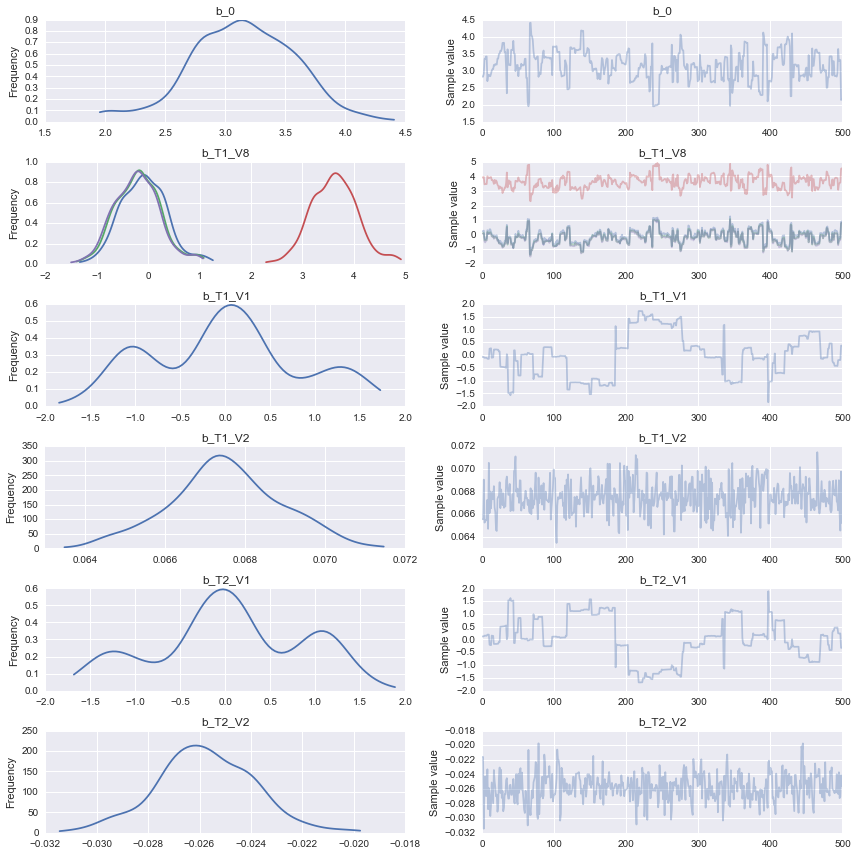

In [77]:
mc.traceplot(trace);

In [80]:
mu = ( trace['b_0'].mean()
      + np.dot(T1_V8, trace['b_T1_V8'].T).mean(1)
      + (trace['b_T1_V1'].mean() * T1_V1)
      + (trace['b_T1_V2'].mean() * T1_V2)
      + (trace['b_T2_V1'].mean() * T2_V1)
      + (trace['b_T2_V2'].mean() * T2_V2)
#       + (trace['b_T1_V1_T1_V2'].mean() * T1_V2 * T1_V1)
      )

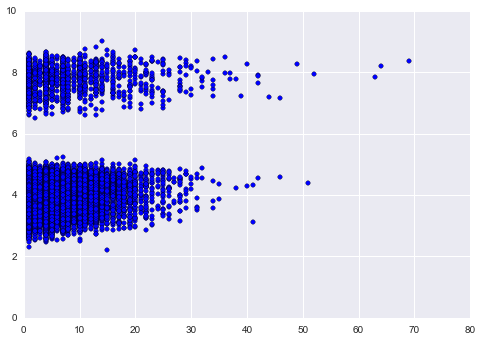

In [86]:
plt.scatter(y,mu)
plt.xlim((0,80))
plt.ylim((0,10))
plt.show()